# Topological Uncertainty and Topological Difference

**Goal:** We want to experimentally test the differences between Topological Uncertainty (TD) and Topological DIfference (TD).

### Import libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import from external libraries.

In [2]:
import numpy as np
import matplotlib.pylab as plt

Import our implementation to compute topological uncertainty

In [3]:
import utils.utils_graphs as ug
import utils.utils_notebook as unb
import utils.utils_tda as utda

2022-02-25 16:53:15.158243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 16:53:15.158259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 2. Topological uncertainty on tensorflow neural network

For this section, you need `tensorflow 2` installed.

In [4]:
import tensorflow as tf

## 2.1 A First example

We briefly show how you can use TU on a simple tensorflow sequential network. We showcase this using the MNIST dataset.

In [5]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_train = x_train.reshape(len(x_train), 784)

x_test = x_test / 255.0
x_test = x_test.reshape(len(x_test), 784)

labels = np.unique(y_train)
nlabels = len(labels)

We know build a tensorflow model with 2 hidden layers with 64 and 16 units, respectively.

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[x_train.shape[1]]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(nlabels, activation='softmax'),
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer='adam'
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                                 
Total params: 51,450
Trainable params: 51,450
Non-trainable params: 0
_________________________________________________________________


2022-02-25 16:53:16.284817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 16:53:16.284997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 16:53:16.285021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-25 16:53:16.285040: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-25 16:53:16.285060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Now we compile and train the model. It should easily reach ~ 98% of (training) accuracy.

In [7]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

num_epochs = 10
model.fit(x_train, y_train, epochs=num_epochs)

Epoch 1/10
   1/1875 [..............................] - ETA: 5:48 - loss: 2.4261 - accuracy: 0.0312

/home/felix/.cache/pypoetry/virtualenvs/topologicaluncertainty-FuTyNJF2-py3.9/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1875/1875 [==============================] - 1s 596us/step - loss: 0.3345 - accuracy: 0.9048
Epoch 2/10
1875/1875 [==============================] - 1s 600us/step - loss: 0.1494 - accuracy: 0.9563
Epoch 3/10
1875/1875 [==============================] - 1s 596us/step - loss: 0.1095 - accuracy: 0.9673
Epoch 4/10
1875/1875 [==============================] - 1s 592us/step - loss: 0.0881 - accuracy: 0.9732
Epoch 5/10
1875/1875 [==============================] - 1s 598us/step - loss: 0.0712 - accuracy: 0.9780
Epoch 6/10
1875/1875 [==============================] - 1s 591us/step - loss: 0.0614 - accuracy: 0.9807
Epoch 7/10
1875/1875 [==============================] - 1s 593us/step - loss: 0.0518 - accuracy: 0.9840
Epoch 8/10
1875/1875 [==============================] - 1s 591us/step - loss: 0.0455 - accuracy: 0.9857
Epoch 9/10
1875/1875 [==============================] - 1s 588us/step - loss: 0.0395 - accuracy: 0.9876
Epoch 10/10
1875/1875 [==============================] - 1s 593us/step - lo

We briefly check that it did not grossly overfit (this experiment is just for illustrative purpose, we do not aim to have a fine-tuned network). In the following cell, `accuracy` should be about 97%.

In [8]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 413us/step - loss: 0.0961 - accuracy: 0.9732


[0.0961277186870575, 0.9732000231742859]

Now, for **each class** and **only the final layer**, we will:
- Build the activation graphs for each training observation. Note: there are 6,000 observations per class in MNIST; using all of them may be overkill. In the following, we will only use 100 reference observations for each class, which turns out to be sufficient.
- Extract topological features (called _persistence diagrams_) from these activation graphs (which, in our specific setting, can be interpreted as extracting maximum spanning trees from the graphs). 
- Average these persistence diagrams to have a compact summary of how our training observations (for each class) activated the network. This average is encoded by a Fréchet mean, a.k.a. barycenter, of the corresponding diagrams.

Actually, all these three steps are handled by the function `bary_of_set_from_deep_model(model, x, layers_id)`, available from `utils.utils_tda` (imported as `utda` in this notebook). In this function, 
- `model` is our tensorflow model we have trained above.
- `x` is a set of points from which we compute diagrams and average them.
- `layers_id` is a subset of the model layers. Setting `layers_id=None` implies taking all layers into account. Here, as we have 3 layers, and we want to consider only the last one, we set `layers_id=[2]`.

In [9]:
n_obs_per_class = 500

# Take n_obs_per_class observation from each class in x_train:
xs = [x_train[np.where(y_train == ell)][:n_obs_per_class] for ell in labels]

# Now we get the corresponding barycenters.
layers_id = [1]
all_barycenters = [utda.barycenters_of_set_from_deep_model(model, x, layers_id=layers_id) for x in xs]

# and the corresponding mean adjacency matrices

all_mean_adjacency_matrices = [utda.mean_adjacency_matrices_from_deep_model(model, x, layers_id=layers_id) for x in xs]

In [10]:
print(np.max(np.array(all_mean_adjacency_matrices)))
np.array(all_mean_adjacency_matrices).shape

3.820084


(10, 1, 64, 16)

Now, given a new observation, we can get the class assigned by our `model` to it, and compute its distance to the barycenter of this class to check if something weird is happening. 

Let us take, for instance, the first 10 observations of the test set. The first one represents a 7.

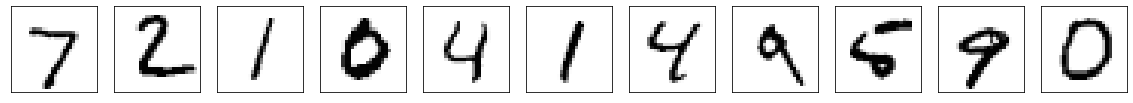

In [11]:
n_new_obs = 11
new_obs = x_test[:n_new_obs]
fig, axs = plt.subplots(1, n_new_obs, figsize=(20,3))
for i,ax in enumerate(axs):
    ax.imshow(new_obs[i].reshape(28,28), cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])

What does our model predict there?

In [12]:
predicted_classes = np.argmax(model.predict(new_obs), axis=-1)
predictions = model.predict(new_obs)
confidences = np.max(predictions, axis=-1)
true_classes = y_test[:n_new_obs]
for i in range(n_new_obs):
    print("class predicted: %s (with confidence = %s%%) --- True label: %s" 
          %(predicted_classes[i], np.round(100*confidences[i], 1), true_classes[i]))
    print("***")

class predicted: 7 (with confidence = 100.0%) --- True label: 7
***
class predicted: 2 (with confidence = 100.0%) --- True label: 2
***
class predicted: 1 (with confidence = 99.8%) --- True label: 1
***
class predicted: 0 (with confidence = 100.0%) --- True label: 0
***
class predicted: 4 (with confidence = 99.8%) --- True label: 4
***
class predicted: 1 (with confidence = 100.0%) --- True label: 1
***
class predicted: 4 (with confidence = 99.4%) --- True label: 4
***
class predicted: 9 (with confidence = 100.0%) --- True label: 9
***
class predicted: 6 (with confidence = 74.9%) --- True label: 5
***
class predicted: 9 (with confidence = 99.8%) --- True label: 9
***
class predicted: 0 (with confidence = 100.0%) --- True label: 0
***


We will also load dome OOD samples from the Fashion MNIST dataset:

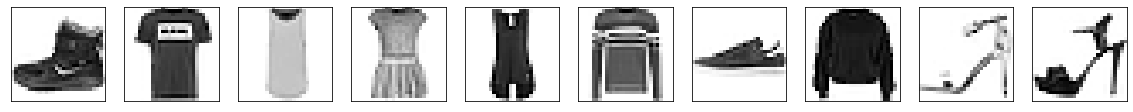

In [13]:
fmnist = tf.keras.datasets.fashion_mnist

(x_train_fmnist, y_train_fmnist) = fmnist.load_data()[0]
x_train_fmnist = x_train_fmnist / 255.0
x_train_fmnist = x_train_fmnist.reshape(len(x_train_fmnist), 784)

nplots = 10
fix, axs = plt.subplots(1, nplots, figsize=(20,3))

for i, ax in enumerate(axs):
    (ax.imshow(x_train_fmnist[i].reshape(28,28), cmap='Greys'), ax.set_xticks([]), ax.set_yticks([]))

In [14]:
ood_samples = x_train_fmnist[:n_new_obs]
predictions = model.predict(ood_samples)
predicted_classes_ood = np.argmax(predictions, axis=-1)
confidences = np.max(predictions, axis=-1)
# Gather the predicted classes for later use:
pred_classes_list = [predicted_classes, predicted_classes_ood]

Let's plot the confidences per class and overlay them with the prediction (red dot). 

In [15]:
# print('Standard Confidence:\nPredicted classes: ', predicted_classes)
# plt.imshow(predictions)
# plt.scatter(x=predicted_classes, y=list(range(len(predicted_classes))), color='red', s=40)
# plt.colorbar()
# print('x-axis: class labels,\ny-axis: input samples\nred dots: predicted class')

As we can see, our network is correct most of the time (unless one has been very unlucky with the random seed used for training) and is quite confident in its predictions.

Now, what's the _Topological uncertainty_ of these new observations? That is, what is the distance between the persistence diagrams (of the activation graphs) of these new observations and the barycenters of the corresponding class?

In [16]:
# First, we compute the diagram of this new observation
utda.topological_uncertainty(model, new_obs, all_barycenters, layers_id=layers_id, all_classes=False)

array([0.02842309, 0.04313748, 0.03362607, 0.04314293, 0.03413767,
       0.01323962, 0.03737536, 0.02062145, 0.0400699 , 0.02403882,
       0.0242465 ])

Let's look at the TU w.r.t. all classes in case of new samples as well as for new OOD samples (Fashion-MNIST)

Topological Uncertainty:
************************
Predicted classes:  [7 2 1 0 4 1 4 9 6 9 0] 
Predicted classes OOD:  [2 8 1 1 3 6 2 0 5 2 3]
x-axis: class labels (10)
y-axis: input samples (11)
red dots: predicted (and correct in case of MNIST) class


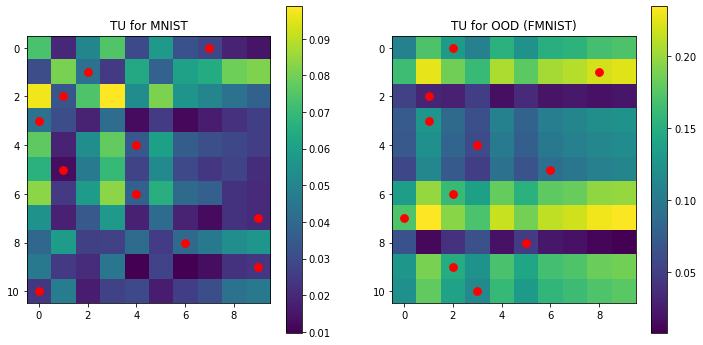

In [17]:
print('Topological Uncertainty:\n************************\nPredicted classes: ', predicted_classes, '\nPredicted classes OOD: ', predicted_classes_ood)
TU_pred_class = utda.topological_uncertainty(model, new_obs, all_barycenters, layers_id=layers_id, all_classes=False)
TU = utda.topological_uncertainty(model, new_obs, all_barycenters, layers_id=layers_id, all_classes=True)
## For OOD samples:
TU_ood_pred_class = utda.topological_uncertainty(model, ood_samples, all_barycenters, layers_id=layers_id, all_classes=False)
TU_ood = utda.topological_uncertainty(model, ood_samples, all_barycenters, layers_id=layers_id, all_classes=True)

## Plot:
titles = ['TU for MNIST', 'TU for OOD (FMNIST)']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ix, TU_v in enumerate([TU, TU_ood]):
    im = axs[ix].imshow(TU_v)
    axs[ix].scatter(x=pred_classes_list[ix], y=list(range(n_new_obs)), color='red', s=60)
    axs[ix].set_title(titles[ix])
    plt.colorbar(im, ax=axs[ix])

print('x-axis: class labels (10)\ny-axis: input samples (11)\nred dots: predicted (and correct in case of MNIST) class')

In [18]:
print(np.mean(TU, axis=1) - np.mean(TU_ood, axis=1))
print(np.var(TU, axis=1) - np.var(TU_ood, axis=1))

[-0.10362138 -0.14074888  0.03262397 -0.07463952 -0.05083894 -0.04770431
 -0.12443478 -0.17674202  0.0104562  -0.13627459 -0.12029236]
[-9.53182343e-05 -1.18731731e-04  3.70679984e-04 -3.40809199e-04
  8.30721047e-06 -1.28388411e-04 -2.78096387e-05 -2.86586240e-04
 -2.81047388e-04 -3.76044249e-04 -3.73982083e-04]


In [19]:
# utda.topological_difference(model, new_obs, all_mean_adjacency_matrices, layers_id=layers_id, all_classes=False)
# all_mean_adjacency_matrices[1].shape

Topological Difference:
***********************
Predicted classes:  [7 2 1 0 4 1 4 9 6 9 0]
x-axis: class labels (10)
y-axis: input samples (11)
red dots: predicted (and correct in case of MNIST) class


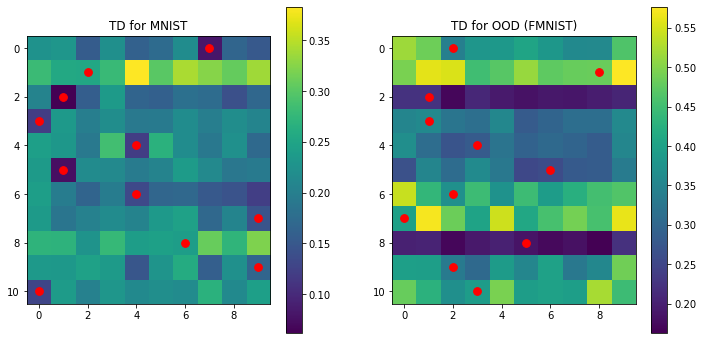

In [34]:
dimension = 0
print('Topological Difference:\n***********************\nPredicted classes: ', predicted_classes)
TD_pred_class = utda.topological_difference(model, new_obs, all_mean_adjacency_matrices, layers_id=layers_id, all_classes=False, absolute_value=True, dim=dimension)
TD , diags,_, matrix_diff= utda.topological_difference(model, new_obs, all_mean_adjacency_matrices, layers_id=layers_id, all_classes=True, absolute_value=True, dim=dimension)
## For OOD samples:
TD_ood_pred_class = utda.topological_difference(model, ood_samples, all_mean_adjacency_matrices, layers_id=layers_id, all_classes=False, absolute_value=True, dim=dimension)
TD_ood, _,_, matrix_diff_ood = utda.topological_difference(model, ood_samples, all_mean_adjacency_matrices, layers_id=layers_id, all_classes=True, absolute_value=True, dim=dimension)

## Plot:
titles = ['TD for MNIST', 'TD for OOD (FMNIST)']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ix, TD_v in enumerate([TD, TD_ood]):
    im = axs[ix].imshow(TD_v)
    axs[ix].scatter(x=pred_classes_list[ix], y=list(range(n_new_obs)), color='red', s=60)
    axs[ix].set_title(titles[ix])
    plt.colorbar(im, ax=axs[ix])

print('x-axis: class labels (10)\ny-axis: input samples (11)\nred dots: predicted (and correct in case of MNIST) class')

In [21]:

# prune_val = np.max(np.array(matrix_diff)) - np.min(np.array(matrix_diff))
# np.array(diags, dtype=object)

In [22]:
# TD_pred_class

In [23]:
print(np.mean(TD, axis=1) - np.mean(TD_ood, axis=1))
print(np.var(TD, axis=1) - np.var(TD_ood, axis=1))

[-0.01475408 -0.0105002         -inf -0.0064331  -0.00591519 -0.00820575
 -0.01751528 -0.02050188  0.0071898  -0.00989158 -0.01223282]
[ 2.43247866e-06  2.06853900e-06             nan  5.04092049e-06
  7.93936632e-06  4.37183109e-06 -4.22106177e-06 -7.42826108e-06
  5.45995026e-06  8.78869416e-06  1.74565114e-06]


/home/felix/.cache/pypoetry/virtualenvs/topologicaluncertainty-FuTyNJF2-py3.9/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [24]:
#np.max(np.abs(np.array(diags)))
# print('Max value of adjacency matrices:', np.max(np.array(adjacency_matrices)))
# np.array(adjacency_matrices).shape

In [25]:
# print(np.array(all_mean_adjacency_matrices[1][0]).shape)
# (adjacency_matrices[2][0] - all_mean_adjacency_matrices[1][0]).shape

Let's look at what happens if we take the norm of the differences of the adjacency matrices directly, without computing their persistence diagrams:

Norms of differences of the adjacency matrices:
***********************************************
Predicted classes:  [7 2 1 0 4 1 4 9 6 9 0]
x-axis: class labels (10)
y-axis: input samples (11)
red dots: predicted (and correct in case of MNIST) class


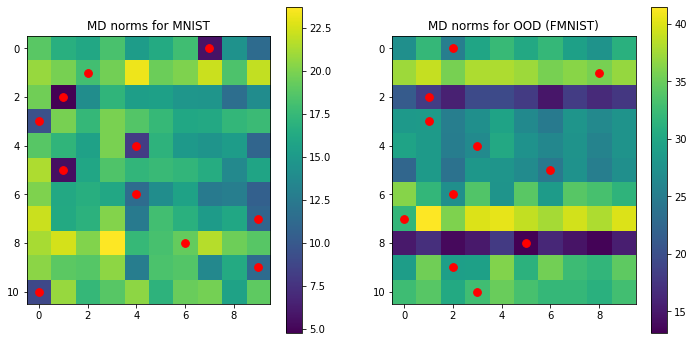

In [26]:
print('Norms of differences of the adjacency matrices:\n***********************************************\nPredicted classes: ', predicted_classes)
from numpy import linalg as LA
MD = np.transpose(np.array(matrix_diff)).squeeze()
MD_ood = np.transpose(np.array(matrix_diff_ood)).squeeze()
#print(MD.shape)
#np.max(MD)
MD_norms = LA.norm(MD, axis=(0,1))
MD_norms_ood = LA.norm(MD_ood, axis=(0,1))

## Plot:
titles = ['MD norms for MNIST', 'MD norms for OOD (FMNIST)']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ix, MD_v in enumerate([MD_norms, MD_norms_ood]):
    im = axs[ix].imshow(MD_v)
    axs[ix].scatter(x=pred_classes_list[ix], y=list(range(n_new_obs)), color='red', s=60)
    axs[ix].set_title(titles[ix])
    plt.colorbar(im, ax=axs[ix])

print('x-axis: class labels (10)\ny-axis: input samples (11)\nred dots: predicted (and correct in case of MNIST) class')

In [27]:
# print(np.array(diags).shape)
# np.max(np.array(diags))

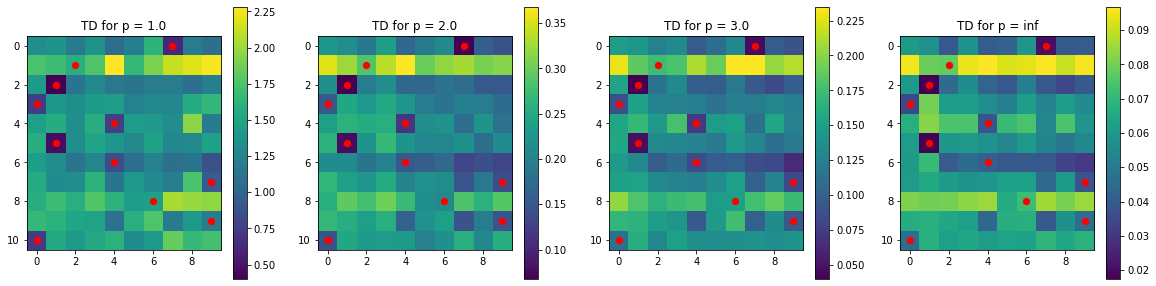

In [28]:
# Let's see the effect of the choice of 'p' in [1,+inf].
p_s = [1., 2., 3., np.inf]
fig, axs = plt.subplots(1, len(p_s), figsize=(20, 5))
for ix,p in enumerate(p_s):
    TD, diags, _, _ = utda.topological_difference(model, new_obs, all_mean_adjacency_matrices, layers_id=layers_id, p=p, all_classes=True, absolute_value=True)
    im = axs[ix].imshow(TD)
    axs[ix].scatter(x=predicted_classes, y=list(range(len(predicted_classes))), color='red', s=40)
    axs[ix].set_title(f'TD for p = {p}')
    plt.colorbar(im, ax=axs[ix])

In [29]:
np.array(all_mean_adjacency_matrices).shape

(10, 1, 64, 16)

In [30]:
# We now define cumulative version of TU, where we sum up the TU w.r.t. each non-predicted class and subtract the TU w.r.t. the predicted class.

TU[list(range(len(predicted_classes))), predicted_classes] *= -1
# TU *= -1
TU_cumulative = np.sum(TU, axis=1)


#We do the same for TD:
TD[list(range(len(predicted_classes))), predicted_classes] *= -1
# TD *= -1
TD_cumulative = np.sum(TD, axis=1)
print('TU cumulative:\n', TU_cumulative)
print('TD cumulative:\n', TD_cumulative)

TU cumulative:
 [0.3433013  0.48102008 0.55760008 0.16347618 0.37535565 0.35254589
 0.39973423 0.25703215 0.33527998 0.1953316  0.25966719]
TD cumulative:
 [0.41678848 0.75499398 0.39172924 0.50825784 0.59080967 0.49062859
 0.357306   0.49620523 0.65339023 0.49090248 0.53774296]


In [31]:
# print('Standard Confidence:\nPredicted classes: ', predicted_classes)
# plt.imshow(predictions)
# plt.scatter(x=predicted_classes, y=list(range(len(predicted_classes))), color='red', s=40)
# plt.colorbar()
# print('x-axis: class labels,\ny-axis: input samples\nred dots: predicted class')

In [32]:
# # We now define cumulative version of TU, where we sum up the TU w.r.t. each non-predicted class and subtract the TU w.r.t. the predicted class.

# TU_ood[list(range(len(predicted_classes))), predicted_classes] *= -1
# # TU_ood *= -1
# TU_ood_cumulative = np.sum(TU_ood, axis=1)


# #We do the same for TD:
# TD_ood[list(range(len(predicted_classes))), predicted_classes] *= -1
# # TD_ood *= -1
# TD_ood_cumulative = np.sum(TD_ood, axis=1)

# print('TU:\n', TU_pred_class)
# print('TU ood:\n', TU_ood_pred_class)
# print('TU cumulative:\n', TU_cumulative)
# print('TU ood cumulative:\n', TU_ood_cumulative)
# print('TD:\n', TD_pred_class)
# print('TD ood:\n', TD_ood_pred_class)
# print('TD cumulative:\n', TD_cumulative)
# print('TD ood cumulative:\n', TD_ood_cumulative)

In [33]:
# fig, axs = plt.subplots(2, 3, figsize=(24, 6))
# x = list(range(len(TU_pred_class)))

# axs[0,0].scatter(x, TU_pred_class, color='blue', alpha=0.75, label='TU')
# axs[0,1].scatter(x, TU_cumulative, color='blue', alpha=0.75, label='TU cumulative')
# # axs[0,0].scatter(x, TU_ood_pred_class, color='red', alpha=0.75, label='TU ood')
# # axs[0,0].scatter(x, TU_ood_cumulative, color='black', alpha=0.75, label='TU ood cumulative')

# axs[0,0].scatter(x, TD_pred_class, color='green', alpha=0.75, label='TD')
# axs[0,1].scatter(x, TD_cumulative, color='green', alpha=0.75, label='TD cumulative')
# # axs[0,1].scatter(x, TD_ood_pred_class, color='red', alpha=0.75, label='TD ood')
# # axs[0,1].scatter(x, TD_ood_cumulative, color='black', alpha=0.75, label='TD ood cumulative')

# # axs[1,0].scatter(x, TU_pred_class, color='blue', alpha=0.75, label='TU')
# # axs[1,0].scatter(x, TU_cumulative, color='green', alpha=0.75, label='TU cumulative')
# axs[1,0].scatter(x, TU_ood_pred_class, color='red', alpha=0.75, label='TU ood')
# axs[1,1].scatter(x, TU_ood_cumulative, color='red', alpha=0.75, label='TU ood cumulative')

# # axs[1,1].scatter(x, TD_pred_class, color='blue', alpha=0.75, label='TD')
# # axs[1,1].scatter(x, TD_cumulative, color='green', alpha=0.75, label='TD cumulative')
# axs[1,0].scatter(x, TD_ood_pred_class, color='black', alpha=0.75, label='TD ood')
# axs[1,1].scatter(x, TD_ood_cumulative, color='black', alpha=0.75, label='TD ood cumulative')

# axs[0,2].scatter(x, TU_ood_pred_class - TU_pred_class, color='black', alpha=0.75, label='TU ood - TU')
# axs[0,2].scatter(x, TD_ood_pred_class - TD_pred_class, color='red', alpha=0.75, label='TD ood - TD')

# axs[1,2].scatter(x, TU_ood_cumulative - TU_cumulative, color='black', alpha=0.75, label='TU ood cum - TU cum')
# axs[1,2].scatter(x, TD_ood_cumulative - TD_cumulative, color='red', alpha=0.75, label='TD ood cum - TD cum')

# axs[0,0].legend(fontsize=12)
# axs[0,1].legend(fontsize=12)
# axs[1,0].legend(fontsize=12)
# axs[1,1].legend(fontsize=12)
# axs[0,2].legend(fontsize=12)
# axs[1,2].legend(fontsize=12)

# plt.show()